In [41]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import re

title = 'woplus'
path = '../../sources/data'

## Load Data
### Internal Data 内部数据，赛题直接提供

In [2]:
df_net = pd.read_table('{}/dataset_2015_filter_net.txt'.format(path), sep='|')
df_net_piv = df_net.pivot(index='imsi', columns='mon')
df_net_piv.columns = ['net01','net02','net03','net04','net05','net06','net07','net08','net09','net10','net11','net12']

df_age = pd.read_table('{}/dataset_2015_filter_age.txt'.format(path), sep='|')
df_age_piv = df_age.pivot(index='imsi', columns='mon')
df_age_piv.columns = ['age01','age02','age03','age04','age05','age06','age07','age08','age09','age10','age11','age12']

df_sex = pd.read_table('{}/dataset_2015_filter_sex.txt'.format(path), sep='|')
df_sex_piv = df_sex.pivot(index='imsi', columns='mon')
df_sex_piv.columns = ['sex01','sex02','sex03','sex04','sex05','sex06','sex07','sex08','sex09','sex10','sex11','sex12']

df_arpu = pd.read_table('{}/dataset_2015_filter_arpu.txt'.format(path), sep='|')
df_arpu_piv = df_arpu.pivot(index='imsi', columns='mon')
df_arpu_piv.columns = ['arpu01','arpu02','arpu03','arpu04','arpu05','arpu06','arpu07','arpu08','arpu09','arpu10','arpu11','arpu12']

df_stream = pd.read_table('{}/dataset_2015_filter_stream.txt'.format(path), sep='|')
df_stream_piv = df_stream.pivot(index='imsi', columns='mon')
df_stream_piv.columns = ['stream01','stream02','stream03','stream04','stream05','stream06','stream07','stream08','stream09','stream10','stream11','stream12']

df_sms = pd.read_table('{}/dataset_2015_filter_sms.txt'.format(path), sep='|')
df_sms_piv = df_sms.pivot(index='imsi', columns='mon')
df_sms_piv.columns = ['sms01','sms02','sms03','sms04','sms05','sms06','sms07','sms08','sms09','sms10','sms11','sms12']

df_talklen = pd.read_table('{}/dataset_2015_filter_talklen.txt'.format(path), sep='|')
df_talklen_piv = df_talklen.pivot(index='imsi', columns='mon')
df_talklen_piv.columns = ['talklen01','talklen02','talklen03','talklen04','talklen05','talklen06','talklen07','talklen08','talklen09','talklen10','talklen11','talklen12']

df_me = pd.read_table('{}/dataset_2015_filter_me.txt'.format(path), sep='|')
df_me_piv = df_me.pivot(index='imsi', columns='mon')
df_me_piv.columns = ['brand01','brand02','brand03','brand04','brand05','brand06','brand07','brand08','brand09','brand10','brand11','brand12',\
                     'type01','type02','type03','type04','type05','type06','type07','type08','type09','type10','type11','type12']

### External Data

In [3]:
# 重新加载新的终端库信息
df_tacinfo = pd.read_csv('{}/tacinfo_for_woplus_deal_utf8.csv'.format(path))
df_tacinfo.columns = ['brand','type','brandtype','sumusers','avgusers','prices','sales_date','iselder','isnetcard','ispad']
df_tacinfo = df_tacinfo.loc[:, ['brand','type','prices','sales_date','iselder','isnetcard','ispad']]
df_tacinfo.iselder = df_tacinfo.iselder.fillna(0)
df_tacinfo.isnetcard = df_tacinfo.isnetcard.fillna(0)
df_tacinfo.ispad = df_tacinfo.ispad.fillna(0)
df_tacinfo.prices = df_tacinfo.prices.fillna(0)
df_tacinfo.head()

,brand,type,prices,sales_date,iselder,isnetcard,ispad
0,Apple,iPhone 5S,2500.0,2013/9/1,0.0,0.0,0.0
1,Apple,iPhone 5,2000.0,2012/9/1,0.0,0.0,0.0
2,Apple,iPhone 4,500.0,2010/10/1,0.0,0.0,0.0
3,Apple,iPhone 4S,800.0,2011/10/1,0.0,0.0,0.0
4,Apple,iPhone 6 (A1586),3890.0,2014/9/1,0.0,0.0,0.0


In [178]:
print df_tacinfo[df_tacinfo.brand == '苹果'].head(2)
print df_tacinfo[df_tacinfo.brand == u'苹果'].head(2)

  brand   type  prices sales_date  iselder  isnetcard  ispad
6    苹果  A1429  2000.0   2012/9/1      0.0        0.0    0.0
7    苹果  A1586  3890.0   2014/9/1      0.0        0.0    0.0
Empty DataFrame
Columns: [brand, type, prices, sales_date, iselder, isnetcard, ispad]
Index: []


## Data Summary

In [4]:
def ValueCounts(das, nhead=5):
    tmp = pd.value_counts(das).reset_index().rename_axis({'index': das.name}, axis=1)
    value = pd.DataFrame(['Value {}'.format(x+1) for x in np.arange(nhead)], index=np.arange(nhead)).join(tmp.iloc[:, 0], how='left').set_index(0).T
    freq = pd.DataFrame(['Freq {}'.format(x+1) for x in np.arange(nhead)], index=np.arange(nhead)).join(tmp.iloc[:, 1], how='left').set_index(0).T
    nnull = das.isnull().sum()
    freqother = pd.DataFrame({das.name: [das.shape[0] - nnull - np.nansum(freq.values), nnull]}, index=['Freq Others','Freq NA']).T
    op = pd.concat([value, freq, freqother], axis=1)
    return op

def Summary(da):
    op = pd.concat([pd.DataFrame({'type':da.dtypes, 'nnullCount':da.notnull().sum(axis=0)}), da.describe().T.iloc[:, 1:],
          pd.concat(map(lambda i: ValueCounts(da.loc[:,i]), da.columns))], axis=1).loc[da.columns]
    op.index.name='columns'
    return op

## Category Feature's Bin with OHC

In [5]:
'''Transfrom a categorical column to onehotencoding'''
def Cat_to_bin(das, a = 0.0):
    tmp = pd.value_counts(das)/das.shape[0]
    cat = list(tmp.index[tmp >= a]) # 改良：增加等于0，确保即使某个bin没有值，也会被ohc编码；同时相应修改下面去掉=
    cat.sort()   # 改良：使用cat前对cat进行一次排序，保证顺序一致
    enc = OneHotEncoder(n_values = len(cat)+1, sparse = False)
    xbin = enc.fit_transform(np.transpose(
            [das.astype("category").cat.set_categories(cat).cat.rename_categories(1+np.arange(len(cat))).astype("float").fillna(0).values]))[:,1:]     
    dabin = pd.DataFrame(xbin, columns = ["{}_{}".format(das.name[:-2], x) for x in cat], index = das.index)    # origin
    # dabin = pd.DataFrame(xbin, columns = ["{}_{}".format(das.name, x) for x in (1+np.arange(len(cat)))], index = das.index) 
    if(tmp[tmp < a].sum() > a):
        dabin = pd.concat([dabin, pd.DataFrame({"{}_Others".format(das.name[:-2]):das.notnull()-dabin.sum(axis = 1)})], axis = 1)
    if(dabin.shape[1] == 2):
        dabin = pd.DataFrame({das.name[:-2]: xbin[:,0]}, index = das.index)
    return(dabin)

def CattoBin(da, a = 0.0):
    op = pd.concat(map(lambda i: Cat_to_bin(da.loc[:, i], a), da.columns), axis=1)
    return op

## Numerical Feature's Standardalization with StandardScaler

In [6]:
def SSTraining(da):
    ss = StandardScaler().fit(da)
    # ss.mean_
    # ss.scale_
    newColumns = []
    for col in da.columns:
        newColumns.append(col[:-2])
    op = pd.DataFrame(ss.transform(da), index=da.index, columns=newColumns)
    return op, ss

## Label's Generation

In [7]:
def isChangingStrict(dl):
    return len(np.unique(dl))

def labelGenerate(df, Mon1, Mon2):
    df_phone = df.loc[:,['brand'+Mon1,'type'+Mon1,'brand'+Mon2,'type'+Mon2]]
    df_phone_label_strict = df_phone.apply(isChangingStrict, axis=1)
    df_phone_label_strict[df_phone_label_strict < 3] = 0
    df_phone_label_strict[df_phone_label_strict >=3] = 1
    return pd.DataFrame(df_phone_label_strict, columns=['Flag'])

## Select df's Columns

In [8]:
def dfSelCol(df, mon):
    featList = df.columns.tolist()
    return df.loc[:, map(lambda i: re.findall('\d{2}',featList[i])[0] == mon, np.arange(len(featList)))]

## Feature's Generation

### Baseline-1

In [25]:
def featGenerate(mon):
    df_net_piv_sel     = dfSelCol(df_net_piv, mon)
    df_age_piv_sel     = dfSelCol(df_age_piv, mon)
    df_sex_piv_sel     = dfSelCol(df_sex_piv, mon)
    df_arpu_piv_sel    = dfSelCol(df_arpu_piv, mon)
    df_stream_piv_sel  = dfSelCol(df_stream_piv, mon) 
    df_sms_piv_sel     = dfSelCol(df_sms_piv, mon) 
    df_talklen_piv_sel = dfSelCol(df_talklen_piv, mon)
    
    # deal with Category Features
    net_catbin = CattoBin(df_net_piv_sel)
    age_catbin = CattoBin(df_age_piv_sel)
    sex_catbin = CattoBin(df_sex_piv_sel)
    arpu_catbin = CattoBin(df_arpu_piv_sel)
    stream_catbin = CattoBin(df_stream_piv_sel)
    
    # deal with Numerical Features
    # baseline1.1
#     sms_ss, sscaler_sms = SSTraining(df_sms_piv_sel)
#     talklen_ss, sscaler_talklen = SSTraining(df_talklen_piv_sel)
    
    # baseline1.2
#     sms_norm = (df_sms_piv_sel.rank(pct=True)-0.5/df_sms_piv_sel.shape[0]).apply(st.norm.ppf)
#     sms_norm.columns = ['sms']
#     talklen_norm = (df_talklen_piv_sel.rank(pct=True)-0.5/df_talklen_piv_sel.shape[0]).apply(st.norm.ppf)
#     talklen_norm.columns = ['talklen']
    
    # baseline1.3
    sms_o = df_sms_piv_sel
    sms_o.columns = ['sms']
    talklen_o = df_talklen_piv_sel
    talklen_o.columns = ['talklen']
    # concat
    # 1.1
    # df_features = pd.concat([net_catbin, age_catbin, sex_catbin, arpu_catbin, stream_catbin, sms_ss, talklen_ss], axis=1)
    # 1.2
    # df_features = pd.concat([net_catbin, age_catbin, sex_catbin, arpu_catbin, stream_catbin, sms_norm, talklen_norm], axis=1)
    df_features = pd.concat([net_catbin, age_catbin, sex_catbin, arpu_catbin, stream_catbin, sms_o, talklen_o], axis=1)
    return df_features

### code example
```python
# sms
df_sms_piv_sel = dfSelCol(df_sms_piv, '09') 
pd.qcut(df_sms_piv_sel.sms09, [0,0.5,0.6,0.7,0.8,0.9,1])

# talklen
df_talklen_piv_sel = dfSelCol(df_talklen_piv, '09')
talklen_cat = pd.qcut(df_talklen_piv_sel.talklen09, [0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
print pd.value_counts(talklen_cat)
```
#### sms09
```
Categories (6, interval[float64]):  
[(-0.001, 1.0] < (1.0, 3.0] < (3.0, 8.0] < (8.0, 18.0] < (18.0, 41.0] < (41.0, 16055.0]]
```
#### sms10
```
Categories (6, interval[float64]):  
[(-0.001, 1.0] < (1.0, 3.0] < (3.0, 7.0] < (7.0, 17.0] < (17.0, 38.0] < (38.0, 9741.0]]
```
#### talklen09
```
(-0.001, 3.0]       72446  
(3.0, 31.0]         36381  
(122.0, 188.0]      36333  
(188.0, 277.0]      36066  
(683.0, 11631.0]    36038  
(413.0, 683.0]      35995  
(71.0, 122.0]       35948  
(277.0, 413.0]      35853  
(31.0, 71.0]        35638  
Name: talklen09, dtype: int64
```
#### talklen10
```
(-0.001, 3.0]       74298
(28.0, 67.0]        36664
(263.0, 394.0]      36179
(67.0, 116.0]       36124
(653.3, 12666.0]    36070
(394.0, 653.3]      35886
(178.0, 263.0]      35817
(116.0, 178.0]      35733
(3.0, 28.0]         33927
Name: talklen10, dtype: int64
```

In [106]:
df_sms_piv_sel = dfSelCol(df_sms_piv, '09')
sms_cat = pd.cut(df_sms_piv_sel.sms09, [-1, 0, 1, 5, 10, 20, 50, 100, 200, 20000])

sms09    0
dtype: int64
(-1, 0]         165811
(1, 5]           45446
(20, 50]         38504
(10, 20]         30860
(5, 10]          28321
(0, 1]           23098
(50, 100]        17705
(100, 200]        7686
(200, 20000]      3267
Name: sms09, dtype: int64


In [263]:
df_talklen_piv_sel = dfSelCol(df_talklen_piv, '09')
talklen_bin = [-1,0,10,30]
talklen_bin.extend(range(60,60*11,60))
talklen_bin.extend(range(600+600, 600*7, 600))
talklen_bin.extend([20000])
print talklen_bin
talklen_cat = pd.cut(df_talklen_piv_sel.talklen09, talklen_bin)
print pd.value_counts(talklen_cat)

[-1, 0, 10, 30, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 1200, 1800, 2400, 3000, 3600, 20000]
(-1, 0]          64338
(60, 120]        43480
(120, 180]       33785
(600, 1200]      31372
(30, 60]         27807
(180, 240]       26287
(10, 30]         23631
(240, 300]       21081
(0, 10]          19852
(300, 360]       16522
(360, 420]       13319
(420, 480]       10709
(480, 540]        8588
(1200, 1800]      7977
(540, 600]        7352
(1800, 2400]      2668
(2400, 3000]      1048
(3600, 20000]      442
(3000, 3600]       440
Name: talklen09, dtype: int64


## Feature's Generation - 2

In [42]:
def featGenerate2(mon):
    df_net_piv_sel     = dfSelCol(df_net_piv, mon)
    df_age_piv_sel     = dfSelCol(df_age_piv, mon)
    df_sex_piv_sel     = dfSelCol(df_sex_piv, mon)
    df_arpu_piv_sel    = dfSelCol(df_arpu_piv, mon)
    df_stream_piv_sel  = dfSelCol(df_stream_piv, mon) 
    df_sms_piv_sel     = dfSelCol(df_sms_piv, mon) 
    df_talklen_piv_sel = dfSelCol(df_talklen_piv, mon)
    
    # deal with Category Features
    net_catbin = CattoBin(df_net_piv_sel)
    age_catbin = CattoBin(df_age_piv_sel)
    sex_catbin = CattoBin(df_sex_piv_sel)
    arpu_catbin = CattoBin(df_arpu_piv_sel)
    stream_catbin = CattoBin(df_stream_piv_sel)
    
    # deal with Numerical Features - Discretization and Catbin
    sms_cat = pd.cut(df_sms_piv_sel.iloc[:,-1], [-1, 0, 1, 5, 10, 20, 50, 100, 200, 20000])
    sms_catbin = Cat_to_bin(sms_cat)
    
    talklen_bin = [-1,0,10,30]
    talklen_bin.extend(range(60,60*11,60))
    talklen_bin.extend(range(600+600, 600*7, 600))
    talklen_bin.extend([20000])
    talklen_cat = pd.cut(df_talklen_piv_sel.iloc[:,-1], talklen_bin)
    talklen_catbin = Cat_to_bin(talklen_cat)
    # concat
    df_features = pd.concat([net_catbin, age_catbin, sex_catbin, arpu_catbin, stream_catbin, sms_catbin, talklen_catbin], axis=1)
    return df_features

### Baseline-3

In [51]:
# Baseline-3 增加终端相关特征
def genMeFeats(df, mon, df_tacinfo):
    df_me_sel = dfSelCol(df, mon).reset_index()
    df_me_sel.columns = ['imsi', 'brand', 'type']
    df_me_featadd = df_me_sel.merge(df_tacinfo, left_on=['brand','type'], right_on=['brand','type'], how='left')
    df_me_featadd.set_index('imsi', inplace=True)
    
    # deal with Category Features
    iselder_catbin = CattoBin(df_me_featadd.loc[:, ['iselder']].fillna(0))
    isnetcard_catbin = CattoBin(df_me_featadd.loc[:, ['isnetcard']].fillna(0))
    ispad_catbin = CattoBin(df_me_featadd.loc[:, ['ispad']].fillna(0))
    
    # deal with Numerical Features
    # prices_cat = pd.qcut(df_me_featadd.loc[:,'prices'], [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    prices_cat = pd.cut(df_me_featadd.loc[:,'prices'].fillna(0), [-1,0,100,200,400,500,1000,1500,2000,3000,40000])
    prices_cat.name = 'prices_cat' + mon
    print 'prices_cat value_counts:\n', pd.value_counts(prices_cat)
    prices_catbin = Cat_to_bin(prices_cat)
    # print prices_catbin.head()
    
    # deal datetime feature
    # df_me_09_featadd1.loc[:,['sales_date']]
    salestimediff = datetime.date(2015,int(mon),1) - pd.to_datetime(df_me_featadd['sales_date'])
    salestimediff = salestimediff.astype('timedelta64[D]')
    salestimediffmax = int(np.ceil(salestimediff.max() / 360))
    print 'maximum of salestimediff:', salestimediff.max()
    print 'maximum year of salestimediff:', salestimediffmax
    # print range(0, 30*12*3, 30)
    # print range(30*12*3, 30*12*salestimemax, 360)
    salestimediff_bin = [-1]
    salestimediff_bin.extend(range(0, 30*12*3, 30))
    salestimediff_bin.extend(range(30*12*3, 30*12*(salestimediffmax+1), 360))
    print 'salestimediff_bin:', salestimediff_bin
    salestimediff_cat = pd.cut(salestimediff, salestimediff_bin)
    salestimediff_cat.name = 'salestimediff_cat' + mon
    print 'salestimediff_cat value_counts:\n', pd.value_counts(salestimediff_cat)
    print 'salestimediff_cat length:\n', np.shape(pd.value_counts(salestimediff_cat))
    salestimediff_catbin = Cat_to_bin(salestimediff_cat)
    # print salestimediff_catbin.head()
    return iselder_catbin, isnetcard_catbin, ispad_catbin, prices_catbin, salestimediff_catbin

def featGenerate3(mon):
    tsFeat = featGenerate2(mon)
    df_me_piv_sel = dfSelCol(df_me_piv, mon)
    iselder_catbin, isnetcard_catbin, ispad_catbin, prices_catbin, salestimediff_catbin = genMeFeats(df_me_piv_sel, mon, df_tacinfo)
    # concat
    df_features = pd.concat([tsFeat, iselder_catbin, isnetcard_catbin, ispad_catbin, prices_catbin, salestimediff_catbin], axis=1)
    return df_features

## Generate TrainSet

In [52]:
# comment: mon is string
def genTrainSet(mon1, mon2):
#     tsFeat = featGenerate(mon1)
#     tsFeat = featGenerate2(mon1)
    tsFeat = featGenerate3(mon1)
    tsFeat_norm = (tsFeat.rank(pct=True) - 0.5/tsFeat.shape[0]).apply(st.norm.ppf)
    tsLabel = labelGenerate(df_me_piv, mon1, mon2)
    # 1.1 & 1.2
    # op = pd.concat([tsFeat, tsLabel], axis=1)
    # 1.3 & 2.2 & 3.2
    op = pd.concat([tsFeat_norm, tsLabel], axis=1)
    return op

df_train_09 = genTrainSet('09', '10')
df_train_10 = genTrainSet('10', '11')
df_train_f = pd.concat([df_train_09, df_train_10], axis=0, ignore_index=True)
df_train_f.head()

prices_cat value_counts:
(-1, 0]          100873
(500, 1000]       51553
(200, 400]        43180
(400, 500]        37297
(1500, 2000]      30300
(100, 200]        26503
(0, 100]          22984
(2000, 3000]      18953
(3000, 40000]     18766
(1000, 1500]      10289
Name: prices_cat09, dtype: int64
maximum of salestimediff: 4626.0
maximum year of salestimediff: 13
salestimediff_bin: [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1440, 1800, 2160, 2520, 2880, 3240, 3600, 3960, 4320, 4680]
salestimediff_cat value_counts:
(1080, 1440]    27234
(720, 750]      24390
(420, 450]      20618
(1440, 1800]    19169
(960, 990]      14562
(360, 390]      12647
(-1, 0]          7729
(1800, 2160]     7670
(870, 900]       7426
(540, 570]       7271
(480, 510]       7229
(690, 720]       6407
(570, 600]       4845
(1050, 1080]     4205
(660, 690]       3606
(630, 

,net,age_17岁以下,age_18-22,age_23-25,age_26-29,age_30-39,age_40-49,age_50-59,age_60以上,age_未知,...,"salestimediff_cat_(1440, 1800]","salestimediff_cat_(1800, 2160]","salestimediff_cat_(2160, 2520]","salestimediff_cat_(2520, 2880]","salestimediff_cat_(2880, 3240]","salestimediff_cat_(3240, 3600]","salestimediff_cat_(3600, 3960]","salestimediff_cat_(3960, 4320]","salestimediff_cat_(4320, 4680]",Flag
0,-0.883546,-0.053324,-0.034869,-0.047757,-0.097002,0.870976,-0.237292,-0.16285,-0.130437,-0.012301,...,-0.066656,-0.026654,-0.009997,-0.00221,-0.005132,-0.006296,-0.002964,-0.000021,-0.000003,0
1,0.491520,-0.053324,-0.034869,-0.047757,-0.097002,0.870976,-0.237292,-0.16285,-0.130437,-0.012301,...,-0.066656,-0.026654,-0.009997,-0.00221,-0.005132,-0.006296,-0.002964,-0.000021,-0.000003,0
2,0.491520,-0.053324,-0.034869,-0.047757,-0.097002,0.870976,-0.237292,-0.16285,-0.130437,-0.012301,...,-0.066656,-0.026654,-0.009997,-0.00221,-0.005132,-0.006296,-0.002964,-0.000021,-0.000003,0
3,0.491520,-0.053324,-0.034869,-0.047757,-0.097002,0.870976,-0.237292,-0.16285,-0.130437,-0.012301,...,-0.066656,-0.026654,-0.009997,-0.00221,-0.005132,-0.006296,-0.002964,-0.000021,-0.000003,0
4,0.491520,-0.053324,-0.034869,-0.047757,-0.097002,0.870976,-0.237292,-0.16285,-0.130437,-0.012301,...,1.933747,-0.026654,-0.009997,-0.00221,-0.005132,-0.006296,-0.002964,-0.000021,-0.000003,0


In [228]:
# Summary(df_train_f).to_csv('Summary_df_train_f.csv')

In [15]:
df_train_f.columns

Index([u'net', u'age_17岁以下', u'age_18-22', u'age_23-25', u'age_26-29',
       u'age_30-39', u'age_40-49', u'age_50-59', u'age_60以上', u'age_未知',
       u'sex_不详', u'sex_女', u'sex_男', u'arpu_0-49', u'arpu_100-149',
       u'arpu_150-199', u'arpu_200-249', u'arpu_250-299', u'arpu_300及以上',
       u'arpu_50-99', u'stream_0-499', u'stream_1000-1499',
       u'stream_1500-1999', u'stream_2000-2499', u'stream_2500-2999',
       u'stream_3000-3499', u'stream_3500-3999', u'stream_4000-4499',
       u'stream_4500-4999', u'stream_500-999', u'stream_5000以上', u'sms',
       u'talklen', u'Flag'],
      dtype='object')

In [53]:
m, n = np.shape(df_train_f)
X = df_train_f.iloc[:, :(n-1)].values
y = df_train_f.iloc[:, -1].values

## Training

In [55]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print np.shape(X_train)
print np.shape(X_test)
print np.shape(X_test)[0] * 1.0 / (np.shape(X_train)[0]+np.shape(X_test)[0])

(504977, 119)
(216419, 119)
0.30000027724


In [57]:
# BaseLine by LogisticRegression
LR = LogisticRegression()
LR.fit(X_train, y_train)

yDF = LR.decision_function(X_train)
yHat = LR.predict(X_train)
yScore = LR.predict_proba(X_train)
y_testHat = LR.predict(X_test)
y_testScore = LR.predict_proba(X_test)

In [26]:
# 1. 理解coef_和intercept_
# LR.coef_
# LR.intercept_
print X_train * np.mat(LR.coef_).T + LR.intercept_
print '\n'

# 2. 理解decision_function
# decision_function 实际上就是wTx+b
# np.shape(X_train)
# np.shape(LR.decision_function(X_train))
print LR.decision_function(X_train)
# decision_function 大于0 y_proba > 0.5 正例

# 3. predict与predict_proba
# predict函数源码原理
# a.计算decision_function scores = LR.decision_function(X_train)
# b.

[[-1.21534622]
 [-1.76453161]
 [-1.41870149]
 ..., 
 [-1.28813755]
 [-1.34659094]
 [-1.32841887]]


[-1.21534622 -1.76453161 -1.41870149 ..., -1.28813755 -1.34659094
 -1.32841887]


In [27]:
np.sum(LR.decision_function(X_train) > 0)

0

In [28]:
LR.classes_

array([0, 1])

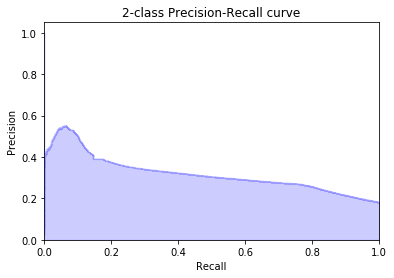

In [247]:
# pr-curve
# Note: this implementation is restricted to the binary classification task.
# Note: Parameter probas_pred can be Estimated probabilities or decision function.

precision, recall, thresholds = precision_recall_curve(y_train, yDF)
# precision_recall_curve(y_train, yScore[:, 1])
    


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

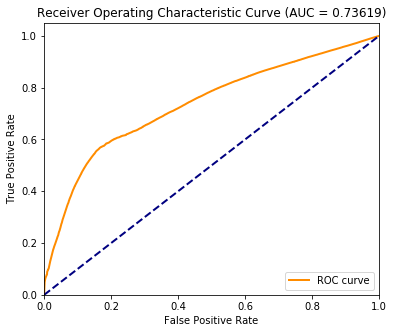

In [60]:
# roc_curve & auc
# Compute Receiver operating characteristic (ROC)
# Note: this implementation is restricted to the binary classification task.
# If labels are not binary, pos_label should be explicitly given.
fpr, tpr, thresholds = roc_curve(y_train, yScore[:,1])
auc(fpr, tpr)

plt.figure(figsize=(6,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (AUC = %.5f)'% roc_auc_score(y_train, yScore[:,1]))
plt.legend(loc="lower right")
# plt.show()
plt.savefig('ROC_Curve_Baseline_3_2.png')

In [61]:
print u'训练集准确度：%.5f' % (np.mean(yHat == y_train))
print u'训练集AUC：%.5f'% roc_auc_score(y_train, yScore[:,1])
print classification_report(y_train, yHat)

print u'验证集准确度：%.2f' % (np.mean(y_testHat == y_test))
print u'验证集AUC：%.5f'% roc_auc_score(y_test, y_testScore[:,1])
print classification_report(y_test, y_testHat)

训练集准确度：0.82755
训练集AUC：0.73619
             precision    recall  f1-score   support

          0       0.83      1.00      0.90    413775
          1       0.84      0.06      0.10     91202

avg / total       0.83      0.83      0.76    504977

验证集准确度：0.83
验证集AUC：0.73096
             precision    recall  f1-score   support

          0       0.83      1.00      0.90    176951
          1       0.84      0.05      0.10     39468

avg / total       0.83      0.83      0.76    216419



## Generate TestSet

In [278]:
df_train_11 = genTrainSet('11', '12')
df_test_f = df_train_11

prices_cat value_counts:
(-1, 0]          92859
(500, 1000]      49774
(200, 400]       40770
(400, 500]       38303
(1500, 2000]     31654
(100, 200]       28936
(0, 100]         27346
(3000, 40000]    21788
(2000, 3000]     18660
(1000, 1500]     10608
Name: prices_cat11, dtype: int64
maximum of salestimediff: 4687.0
maximum year of salestimediff: 14
salestimediff_bin: [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1440, 1800, 2160, 2520, 2880, 3240, 3600, 3960, 4320, 4680, 5040]
salestimediff_cat value_counts:
(1080, 1440]    32092
(780, 810]      23434
(480, 510]      19945
(1800, 2160]    16772
(1020, 1050]    13941
(420, 450]      13624
(1440, 1800]    10653
(60, 90]         9098
(930, 960]       8274
(540, 570]       7302
(750, 780]       6314
(600, 630]       6047
(630, 660]       4715
(300, 330]       3630
(720, 750]       3382
(2160, 252

In [283]:
df_test_f.columns

Index([u'net', u'age_17岁以下', u'age_18-22', u'age_23-25', u'age_26-29',
       u'age_30-39', u'age_40-49', u'age_50-59', u'age_60以上', u'age_未知',
       ...
       u'salestimediff_cat_(1800, 2160]', u'salestimediff_cat_(2160, 2520]',
       u'salestimediff_cat_(2520, 2880]', u'salestimediff_cat_(2880, 3240]',
       u'salestimediff_cat_(3240, 3600]', u'salestimediff_cat_(3600, 3960]',
       u'salestimediff_cat_(3960, 4320]', u'salestimediff_cat_(4320, 4680]',
       u'salestimediff_cat_(4680, 5040]', u'Flag'],
      dtype='object', length=121)

In [287]:
m, n = np.shape(df_test_f)
testX = df_test_f.iloc[:, :(n-2)].values
testy = df_test_f.iloc[:, -1].values

In [288]:
testyHat = LR.predict(testX)
testyScore = LR.predict_proba(testX)
print u'测试集准确度：%.2f' % (np.mean(testyHat == testy)) 
print u'测试集AUC：%.5f'% roc_auc_score(testy, testyScore[:,1])
print classification_report(testy, testyHat)

测试集准确度：0.74
测试集AUC：0.66910
             precision    recall  f1-score   support

          0       0.74      1.00      0.85    267431
          1       0.64      0.01      0.03     93267

avg / total       0.72      0.74      0.64    360698



In [55]:
dfSelCol(df_me_piv, '09').reset_index().groupby(['brand09', 'type09']).count().sort_values(by='imsi', ascending=False)

imsi
brand09   type09                  
苹果        A1429              10008
          A1586               8688
          A1332               8510
          A1528               7557
          A1524               7225
          A1530               6972
          iPhone 4S (A1387)   5348
小米        2013062             3803
          2013029             2862
          2013012             2677
CINTERION AHS3-W              2557
三星        GT-I9300            2038
小米        2013023             1997
          2014021             1996
三星        SM-G7106            1970
          GT-N7100            1889
诺基亚       Nokia 1050          1714
三星        GT-I9500            1608
苹果        A1526               1486
三星        SM-N9002            1467
          GT-I8552            1442
小米        2013022             1348
三星        GT-N7102            1276
小米        2014215             1264
          2014719             1237
          2013061             1193
三星        GT-S7572            1134
小米        2014811             1128
三星        SM-N9006            1124
宏达        HTC D516w           1078
...                            ...
三星        GT-N7102i              1
          GT-I9250T              1
          GT-I9190               1
          GT-I9100M              1
          GT-I9070P              1
          GT-I9020A              1
          SC-04F                 1
          SGH-E250i              1
          SGH-I717               1
          SGH-I727               1
          SM-G710L               1
          SM-G530Y               1
          SM-A500YZ              1
          SM-A500S               1
          SHW-M420K              1
          SHW-M290S              1
          SHW-M290K              1
          SHW-M200S              1
          SHW-M190S              1
          SHV-E470S              1
          SHV-E310S              1
          SHV-E270S              1
          SHV-E270L              1
          SHV-E170L              1
          SGH-i727               1
          SGH-i637               1
          SGH-I997R              1
          SGH-I957M              1
          SGH-I777               1
龙士康       B318                   1

[12450 rows x 1 columns]